<a href="https://colab.research.google.com/github/evillag/TEC-ML-2022-1/blob/main/TP2/src_base/TP2_BayesianModel_MNIST_EVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

In [6]:
%%capture
!wget https://github.com/evillag/TEC-ML-2022-1/raw/main/TP2/src_base/mnist_dataset.zip
!unzip /content/mnist_dataset.zip

train dimensions  torch.Size([784, 600])
train labels  600


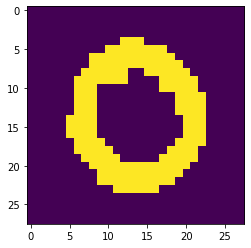

In [7]:

def binarize_image(image_tensor):
    image_tensor[image_tensor > 0.5] = 1
    image_tensor[image_tensor <= 0.5] = 0
    return image_tensor

def load_dataset(path = "mnist_dataset/train"):
    #Open up the dataset
    dataset =  torchvision.datasets.ImageFolder(path)   
    #print(dataset)
    list_images = dataset.imgs
    #print(list_images)
    train_data_tensor  = None    
    labels_training = []
    first_tensor = True
    #list_images_training =  set(data_labeled.train_ds.x.items)
    #print(list_images)
    for i in range(0, len(list_images)):
        pair_path_label = list_images[i]        
        image = Image.open(pair_path_label[0]) 
        x_tensor = TF.to_tensor(image).squeeze()
        x_tensor_bin = binarize_image(x_tensor)

        x_tensor_bin_plain = x_tensor_bin.view(x_tensor_bin.shape[0] * x_tensor_bin.shape[1], -1)        
        #print("tensor ", x_tensor.shape)
        #test dataset case        
        #if("train" in pair_path_label[0]):
        labels_training += [pair_path_label[1]]
        # print(pair_path_label)
        if(first_tensor):
            plt.figure()
            plt.imshow(x_tensor_bin)
            first_tensor = False
            train_data_tensor = x_tensor_bin_plain
        else:
            train_data_tensor = torch.cat((train_data_tensor, x_tensor_bin_plain), 1)    
    return (train_data_tensor, torch.tensor(labels_training))       


(train_data_tensor, labels_training) = load_dataset(path = "/content/mnist_dataset/train")
print("train dimensions ", train_data_tensor.shape)
print("train labels ", len(labels_training))        
    


In [8]:
# def _multiplication_test_model(input_torch, p_m_pix_val_given_k, p_t_tensor, 
#                                num_classes = 10):
#     #assumes that the input comes in a row
#     prob_naive_bayes = torch.zeros(num_classes, train_data_tensor.shape[0])
#     scores_classes = torch.zeros(10)
#     bias = 1.
  
#     for k in range(num_classes):
#       idx_0 = (input_torch == 0.)
#       idx_1 = (input_torch == 1.)
#       prob_naive_bayes[k, idx_0] = (p_m_pix_val_given_k[0][k, idx_0] * p_t_tensor[k]) + bias
#       prob_naive_bayes[k, idx_1] = (p_m_pix_val_given_k[1][k, idx_1] * p_t_tensor[k]) + bias
#       scores_classes[k] = torch.prod(prob_naive_bayes[k,:], dtype=torch.double)

#     values, indices = scores_classes.topk(1)
#     predicted_label = indices[0]
#     #print(scores_classes)
#     #print(f'predicted_label: {indices[0]}. Score = {values[0]}')
    
#     return predicted_label, scores_classes

def test_model(input_torch, p_m_pix_val_given_k, p_t_tensor, 
                               num_classes = 10):
    # assumes that the input comes in a row
    # Since the multiplicatory tends to give very small values, close to 0
    # We are transforming the Naive Bayes by applying a log to it, so that:
    # log(Mul(p(m|t)p(t))) = Sum(log(p(m|t)) + log(p(t)))

    prob_naive_bayes = torch.zeros(num_classes, train_data_tensor.shape[0])
    scores_classes = torch.zeros(10)
      
    for k in range(num_classes):
      idx_0 = (input_torch == 0.) # indices of all pixels in 0
      idx_1 = (input_torch == 1.) # indices of all pixels in 1

      # probability of pixels = 0 given k:
      prob_naive_bayes[k, idx_0] = torch.log(p_m_pix_val_given_k[0][k, idx_0]) + torch.log(p_t_tensor[k])

      # probability of pixels = 1 given k:
      prob_naive_bayes[k, idx_1] = torch.log(p_m_pix_val_given_k[1][k, idx_1]) + torch.log(p_t_tensor[k])

      # calculate the class probability
      scores_classes[k] = torch.sum(prob_naive_bayes[k,:], dtype=torch.double)

    values, indices = scores_classes.topk(1)
    predicted_label = indices[0]
    #print(scores_classes)
    #print(f'predicted_label: {indices[0]}. Score = {values[0]}')
    
    return predicted_label, scores_classes


def test_model_batch(test_set, labels, p_m_pix_val_given_k, p_t_tensor):
    correct = 0
    
    for i in range(labels.shape[0]):
      predicted_label, _ = test_model(test_set[:,i], p_m_pix_val_given_k, 
                                      p_t_tensor)
      correct += 1 if predicted_label == labels[i] else 0
      # print(f'predicted = {predicted_label}. real = {labels[i]}')

    accuracy = correct / labels.shape[0]
    return accuracy


def train_model(train_data_tensor, labels_training, num_classes = 10):
  p_m_0_given_k = torch.zeros(num_classes, train_data_tensor.shape[0])
  p_m_1_given_k = torch.ones(num_classes, train_data_tensor.shape[0])
  
  print(f'p_m_0_given_k shape {p_m_0_given_k.shape}')
  
  _, counts = torch.unique(labels_training, return_counts=True)
  p_t_tensor = counts / len(labels_training)

  for k in range(num_classes):
    training_indices_of_class_k = (labels_training == k).nonzero().squeeze(1)
    M_d = train_data_tensor[:, training_indices_of_class_k]

    # p(m = 0 | k) =>  (observations == 0) / (total observations of class k)
    p_m_0_given_k[k, :] = (M_d == 0.).sum(dim=1).div(M_d.shape[1])

  # calculate complement => p(m = 1 | k)
  p_m_1_given_k = p_m_1_given_k - p_m_0_given_k

  return [p_m_0_given_k, p_m_1_given_k], p_t_tensor
    



#(train_data_tensor, labels_training) = load_dataset()
#print("train dimensions ", train_data_tensor.shape)
#print("train labels ", len(labels_training))

#train model by calculating the prior probabilities
(p_m_pix_val_given_k, p_t_tensor) = train_model(train_data_tensor, labels_training)
print(f"p_m_pix_val_given_k[0] size {p_m_pix_val_given_k[0].shape}")
print(f"p_m_pix_val_given_k[1] size {p_m_pix_val_given_k[1].shape}")
print(f"p_t_tensor \n\tclasses: {p_t_tensor.shape}.\n\tValues: {p_t_tensor}")


(predicted_label, scores_classes) = test_model(train_data_tensor[:, 500], p_m_pix_val_given_k, p_t_tensor)
print("predicted_label ", predicted_label)
print("real label ", labels_training[500])
acc = test_model_batch(train_data_tensor, labels_training, p_m_pix_val_given_k, p_t_tensor)
print("Model accuracy ", acc)
    


p_m_0_given_k shape torch.Size([10, 784])
p_m_pix_val_given_k[0] size torch.Size([10, 784])
p_m_pix_val_given_k[1] size torch.Size([10, 784])
p_t_tensor 
	classes: torch.Size([10]).
	Values: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
predicted_label  tensor(8)
real label  tensor(8)
Model accuracy  0.9166666666666666
